In [26]:
import pandas as pd
from nltk import word_tokenize
from gensim.models import Word2Vec

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [14]:
google_df = pd.read_csv('processed_google_data.csv')
tweets_df = pd.read_csv('processed_cyberbullying_tweets.csv')

google_df.head()


,cyberbullying_type,processed_tweet_text
0,0,game hurt
1,0,right care fuck
2,0,man love reddit
3,0,name nowhere near falcon
4,0,right considering ’ important document know da...


In [15]:
tweets_df.head()

,cyberbullying_type,processed_tweet_text
0,0,words katandandre food crapilicious mkr
1,0,aussietv white mkr theblock imacelebrityau tod...
2,0,xochitlsuckks classy whore red velvet cupcakes
3,0,meh p thanks heads concerned another angry dud...
4,0,rudhoeenglish isis account pretending kurdish ...


In [16]:

combined_df = pd.concat([tweets_df, google_df], ignore_index=True)

FILE = 'processed_concat_data.csv'
combined_df.to_csv(FILE, index=False)



In [17]:
concat_df = pd.read_csv(FILE)

tweets = concat_df['processed_tweet_text'].astype(str).tolist()

tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in tweets]
model_w2v = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

model_w2v.wv['food']


vocab_size = len(model_w2v.wv.key_to_index)
vocab_size

concat_df['word_embeddings'] = concat_df.apply(lambda x : list(), axis=1)

for index, row in concat_df.iterrows():
    for word in word_tokenize(str(row['processed_tweet_text']).lower()):
        row['word_embeddings'].append(model_w2v.wv[word])
    while len(row['word_embeddings']) < 50:
        row['word_embeddings'].append([0]*100)
    

len(concat_df.loc[0, 'word_embeddings'])
len(concat_df.loc[0, 'word_embeddings'][0])


model_w2v.wv['words']

X = concat_df['word_embeddings'].tolist()
y = concat_df['cyberbullying_type'].tolist()

data_0 = concat_df[concat_df['cyberbullying_type'] == 0]
data_1 = concat_df[concat_df['cyberbullying_type'] == 1]


In [18]:
sampled_data_0 = data_0.sample(n=40000, random_state=42)
sampled_data_1 = data_1.sample(n=60000, random_state=42)

balanced_df = pd.concat([sampled_data_0, sampled_data_1])

X_dec = balanced_df['word_embeddings'].tolist()
y_dec = balanced_df['cyberbullying_type'].tolist()

# Shuffle the resulting DataFrame to mix the examples of 0s and 1s
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X_dec, y_dec, test_size=0.3, random_state=42)

In [19]:
# Padding sequences to ensure uniform input size
max_length = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', dtype='float32')

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_test)
        y_pred = np.round(y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)

metrics_callback = MetricsCallback(X_test_padded, y_test)

In [20]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(max_length, 100)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class classification

# Training the model
history = model.fit(X_train_padded, np.array(y_train), epochs=2, batch_size=64, validation_split=0.2, callbacks=[metrics_callback])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_padded, np.array(y_test))
print(f'Test Accuracy: {accuracy}')

Epoch 1/2
875/875 [==============================] - 386s 439ms/step - loss: 0.4473 - accuracy: 0.7640 - val_loss: 0.4255 - val_accuracy: 0.7771
Epoch 2/2
938/938 [==============================] - 61s 65ms/step - loss: 0.4153 - accuracy: 0.7913
Test Accuracy: 0.7912999987602234


In [34]:
def predict_sentiment(sentence, model, word2vec_model):
    # Tokenize and convert to embeddings
    tokens = word_tokenize(sentence.lower())
    print(tokens)
    embeddings = [word2vec_model.wv[token] if token in word2vec_model.wv else np.zeros(100) for token in tokens]
    
    # Pad the sequence
    padded_embeddings = pad_sequences([embeddings], maxlen=max_length, padding='post', dtype='float32')
    print(padded_embeddings)
    # Predict
    prediction = model.predict(padded_embeddings)
    print(prediction)
    # Assuming binary classification with a sigmoid output layer
    predicted_label = 'Positive' if prediction[0][0] < 0.50 else 'Negative'
    
    return predicted_label, prediction[0][0]

# Example usage
test_sentence = "I love you, but I hate you!"

predicted_label, confidence = predict_sentiment(test_sentence, model, model_w2v)

print(f"Sentence: '{test_sentence}'")
print(f"Predicted Sentiment: {predicted_label} (Confidence: {confidence:.2f})")

['i', 'love', 'you', ',', 'but', 'i', 'hate', 'you', '!']
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 1.9381169   0.9373925   0.2216093  ... -2.0377886   0.63188285
    0.52488697]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]]
1/1 [==============================] - 0s 70ms/step
[[0.68095374]]
Sentence: 'I love you, but I hate you!'
Predicted Sentiment: Negative (Confidence: 0.68)


938/938 [==============================] - 59s 62ms/step
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     12038
           1       0.82      0.84      0.83     17962

    accuracy                           0.79     30000
   macro avg       0.78      0.78      0.78     30000
weighted avg       0.79      0.79      0.79     30000



<Axes: >

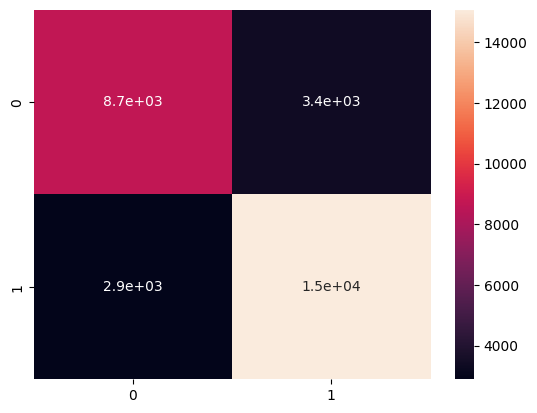

In [36]:
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5)
y_pred = y_pred.astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

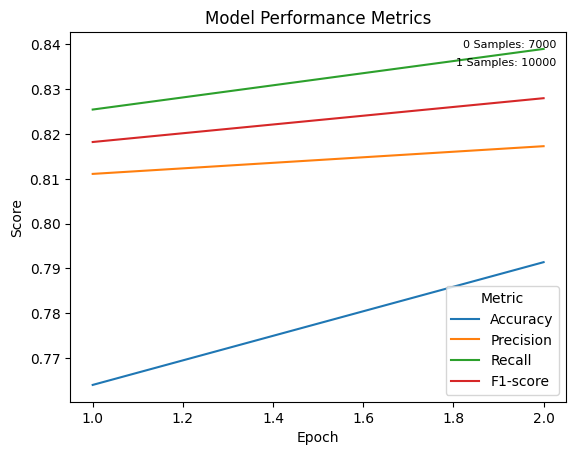

In [35]:
epochs = range(1, len(history.history['loss']) + 1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = metrics_callback.precision_scores
recall = metrics_callback.recall_scores
f1 = metrics_callback.f1_scores

data = pd.DataFrame({'Epoch': epochs, 'Accuracy': accuracy, 'Precision': precision, 
                     'Recall': recall, 'F1-score': f1})
data = pd.melt(data, id_vars=['Epoch'], var_name='Metric', value_name='Score')

sns.lineplot(x='Epoch', y='Score', hue='Metric', data=data)
plt.title('Model Performance Metrics')

plt.text(0.98, 0.98, f'0 Samples: {7000}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=8)
plt.text(0.98, 0.93, f'1 Samples: {10000}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=8)

plt.show()